In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import tensorflow as tf

# Use tf.keras instead of standalone keras
from tensorflow import keras

# Updated import statement for Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
# Updated import statement for pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential # Changed to tf.keras.models
from tensorflow.keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding # Changed to tf.keras.layers
# Removed redundant import: from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import sparse_categorical_crossentropy # Changed to tf.keras.losses
# Updated import statement for Tokenizer (if used again)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence  # Update to tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping # Changed to tf.keras.callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import collections

from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
SEED = 10

In [3]:
#reading the dataset
df = pd.read_csv('/content/WELFake_Dataset.csv')

In [4]:
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

X = df['text']
y = df['label']

<a id = 'eda'></a>
## 1. EDA

In [5]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

<ipython-input-6-3349554665>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

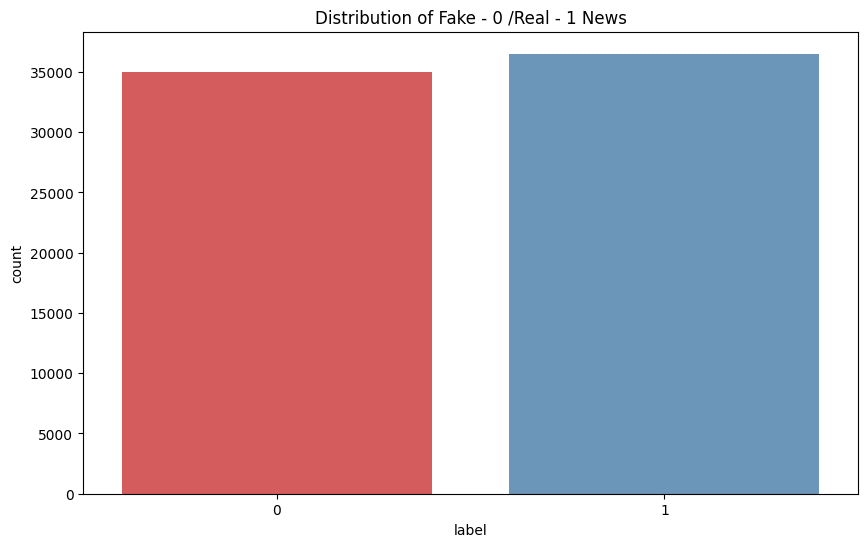

In [6]:
plt.figure(figsize = (10,6))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

<ipython-input-7-1263977490>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of the News Words count')

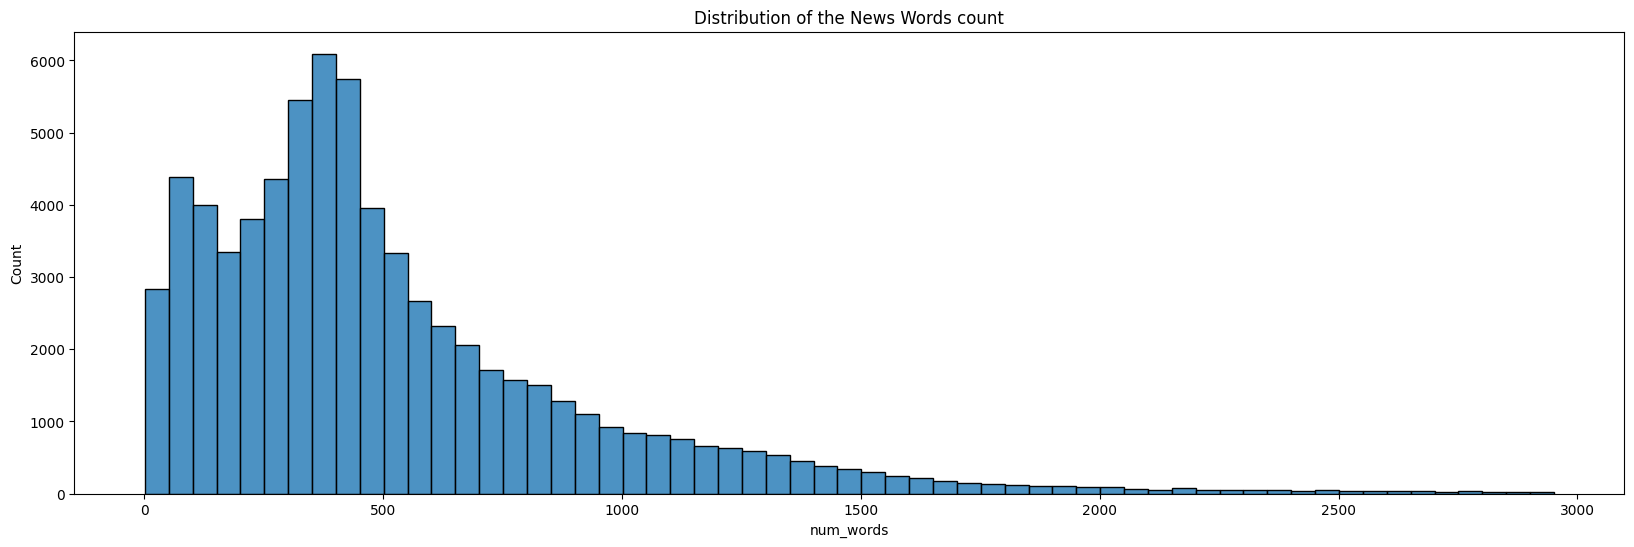

In [7]:
plt.figure(figsize = (20,6))
sns.histplot(df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

<a id = 'prepare_input'></a>
## 2. Preparing the input

In [8]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = SEED)

<a id = 'tokenization'></a>
## 2.1 Tokenization

In [9]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 285418


<a id = 'sequences'></a>
## 2.2 Pad sequences to fixed lenght

In [10]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [11]:
X_train_seq.shape[1]

512

<a id = 'train_evaluate'></a>
## 3. Train and evaluate the Keras LSTM model

<a id = 'define_model'></a>
## 3.1 Define the model

In [12]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 512, 128)       │    36,533,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,969,345 (141.03 MB)

 Trainable params: 36,969,345 (141.03 MB)

 Non-trainable params: 0 (0.00 B)

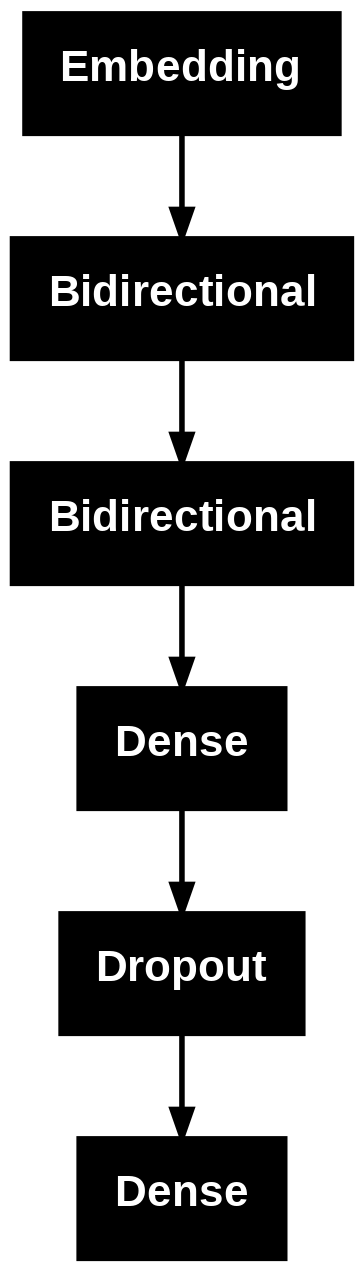

In [13]:
#plot the model architecture
tf.keras.utils.plot_model(model)

<a id = 'train_model'></a>
## 3.2 Training the model

In [14]:
history = model.fit(X_train_seq, y_train, epochs=10, validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - accuracy: 0.7672 - loss: 0.4499 - val_accuracy: 0.9463 - val_loss: 0.1500
Epoch 2/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 142s 125ms/step - accuracy: 0.9635 - loss: 0.1169 - val_accuracy: 0.9554 - val_loss: 0.1225
Epoch 3/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 140s 122ms/step - accuracy: 0.9839 - loss: 0.0572 - val_accuracy: 0.9632 - val_loss: 0.1153
Epoch 4/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 142s 122ms/step - accuracy: 0.9917 - loss: 0.0319 - val_accuracy: 0.9655 - val_loss: 0.1158
Epoch 5/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 137s 115ms/step - accuracy: 0.9957 - loss: 0.0171 - val_accuracy: 0.9627 - val_loss: 0.1419
Epoch 6/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 86s 122ms/step - accuracy: 0.9952 - loss: 0.0176 - val_accuracy: 0.9665 - val_loss: 0.1359
Epoch 7/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 82s 122ms/step - accuracy: 0.9970 - loss: 0.0100 - val_accuracy: 0.9677 - val_loss: 0.1443
Epoch 8/10
671/671 ━━━━━━━━━━━━━━━━━━━━ 146s 128ms/step - accuracy: 0.9967 - lo

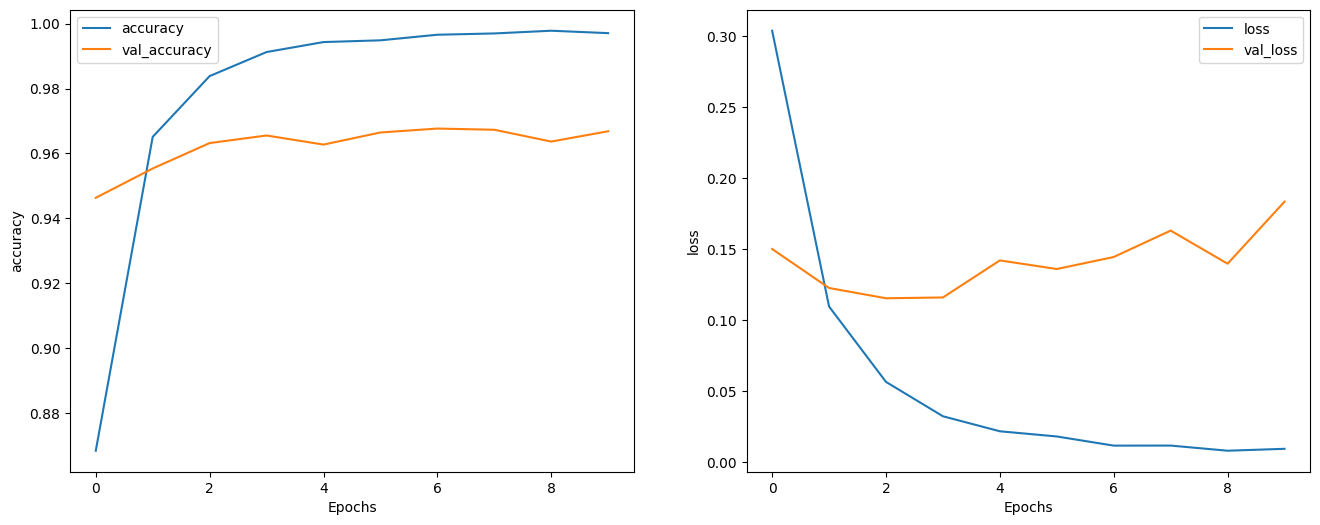

In [15]:
#plot the train/validation loss and accuracy
def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

<a id = 'evaluate_model'></a>
## 3.3 Evaluate the model

In [16]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9653 - loss: 0.1475
559/559 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step
Test Loss: 0.14390869438648224
Test Accuracy: 0.9659491181373596


In [17]:
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8757
           1       0.98      0.95      0.97      9128

    accuracy                           0.97     17885
   macro avg       0.97      0.97      0.97     17885
weighted avg       0.97      0.97      0.97     17885



Text(70.72222222222221, 0.5, 'Real Labels')

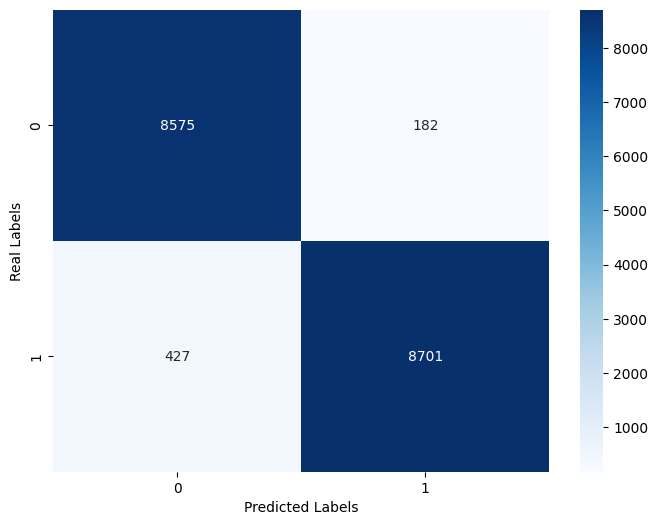

In [18]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [20]:
# Save the model architecture and weights
import pickle

model.save('/content/fake_news_lstm_model.keras')

# Save the tokenizer as well since it is required to preprocess the input data during inference

with open('/content/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tok, handle)


In [21]:
# Load the model
import pickle
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/fake_news_lstm_model.keras')

# Load the tokenizer
with open('/content/tokenizer.pkl', 'rb') as handle:
    loaded_tok = pickle.load(handle)


In [25]:
# Assuming you have already loaded your model and tokenizer as 'loaded_model' and 'loaded_tok'
f ='''Security measures have been heightened around
the Shahi Jama Masjid in Uttar Pradesh's Sambhal ahead of the
Friday prayers, following recent tensions in the area.
The deployment of the Rapid Action Force (RAF) and drones has
added an additional layer of vigilance, ensuring law and order in
the district.
'''

# 1. Preprocess the new text
MAX_LEN = 512
new_sequences = loaded_tok.texts_to_sequences([f])  # Notice the list wrapping
new_padded_seq = sequence.pad_sequences(new_sequences, maxlen=MAX_LEN)

# 2. Predict using the loaded model
prediction = loaded_model.predict(new_padded_seq)

# 3. Interpret the prediction
# The output 'prediction' will be a probability value between 0 and 1.
# If prediction is closer to 1, it's more likely to be real news.
# If prediction is closer to 0, it's more likely to be fake news.
print(f"Prediction: {prediction}")

# You can apply a threshold (e.g., 0.5) to make a binary classification:
if prediction[0][0] >= 0.5:
    print("The model predicts this text is REAL news.")
else:
    print("The model predicts this text is FAKE news.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: [[0.01489565]]
The model predicts this text is FAKE news.
